In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Define batch size
BATCH = 32  # Adjust based on your GPU memory (32, 64, or 128)


In [5]:
dataset_path = '/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv'
df = pd.read_csv(dataset_path)

print("="*60)
print("DATA CLEANING & PREPROCESSING")
print("="*60)
print(f"Original shape: {df.shape}")
print(f"Data types: {df.dtypes.unique()}")


DATA CLEANING & PREPROCESSING
Original shape: (372450, 785)
Data types: [dtype('int64')]


In [6]:
missing = df.isnull().sum().sum()
print(f"\n1. Missing values: {missing}")
if missing > 0:
    print(f"   → Dropping {missing} missing values")
    df = df.dropna()

# 2. Check for duplicates
duplicates = df.duplicated().sum()
print(f"2. Duplicate rows: {duplicates}")
if duplicates > 0:
    print(f"   → Dropping {duplicates} duplicate rows")
    df = df.drop_duplicates()

# 3. Check label range (should be 0-25 for A-Z)
labels_temp = df.iloc[:, 0]
print(f"3. Label range: {labels_temp.min()} to {labels_temp.max()}")
print(f"   Unique labels: {labels_temp.nunique()} (expected: 26)")

# 4. Check pixel value range (should be 0-255)
pixels_temp = df.iloc[:, 1:]
print(f"4. Pixel value range: {pixels_temp.min().min()} to {pixels_temp.max().max()}")

# 5. Check for outliers in labels
valid_labels = (labels_temp >= 0) & (labels_temp <= 25)
invalid_count = (~valid_labels).sum()
if invalid_count > 0:
    print(f"   → Removing {invalid_count} samples with invalid labels")
    df = df[valid_labels]

print(f"\n✓ Clean dataset shape: {df.shape}")
print("="*60)
# Convert to appropriate dtype and extract
df = df.astype(np.uint8)
labels = df.iloc[:, 0].values
images = df.iloc[:, 1:].values.reshape(-1, 28, 28, 1)  # grayscale



1. Missing values: 0
2. Duplicate rows: 171355
   → Dropping 171355 duplicate rows
3. Label range: 0 to 25
   Unique labels: 26 (expected: 26)
4. Pixel value range: 0 to 255

✓ Clean dataset shape: (201095, 785)


In [7]:
images = images / 255.0  # normalize to [0, 1]
print(f"\n✓ Normalized pixel range: [{images.min():.2f}, {images.max():.2f}]")

del df  # free memory

alpha = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')



✓ Normalized pixel range: [0.00, 1.00]


In [8]:
# Step 1: Split into Train (80%) and Test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Step 2: Split Train into Train (80% of 80% = 64%) and Validation (20% of 80% = 16%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print("="*60)
print("DATASET SPLIT")
print("="*60)
print(f"Train:      {X_train.shape} ({len(X_train)/len(images)*100:.1f}%)")
print(f"Validation: {X_val.shape} ({len(X_val)/len(images)*100:.1f}%)")
print(f"Test:       {X_test.shape} ({len(X_test)/len(images)*100:.1f}%)")


DATASET SPLIT
Train:      (128700, 28, 28, 1) (64.0%)
Validation: (32176, 28, 28, 1) (16.0%)
Test:       (40219, 28, 28, 1) (20.0%)



CLASS BALANCE ANALYSIS
Samples per class:
  A: 7,680
  B: 4,804
  C: 12,170
  D: 5,430
  E: 6,039
  F: 1,147
  G: 3,206
  H: 3,974
  I: 1,061
  J: 4,593
  K: 3,156
  L: 6,226
  M: 10,373
  N: 9,909
  O: 29,306
  P: 10,087
  Q: 3,281
  R: 6,170
  S: 24,622
  T: 11,698
  U: 14,921
  V: 2,616
  W: 5,804
  X: 3,557
  Y: 5,833
  Z: 3,432


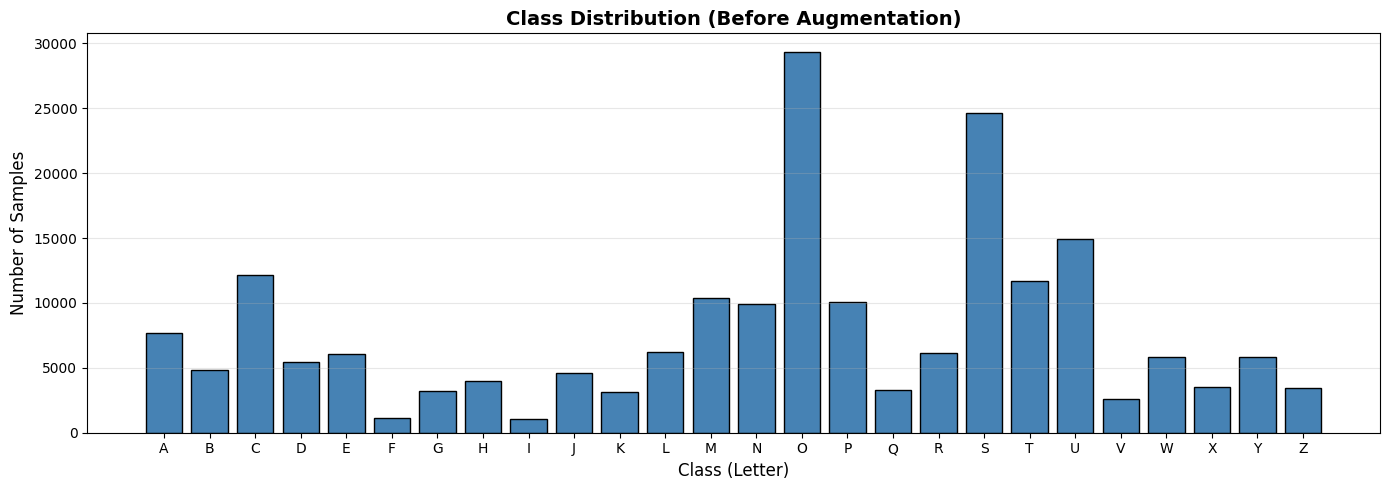


Balance ratio: 0.036 (1.0 = perfectly balanced)
⚠ Dataset is imbalanced (augmentation recommended)


In [9]:
print("\n" + "="*60)
print("CLASS BALANCE ANALYSIS")
print("="*60)

unique, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip([alpha[i] for i in unique], counts))

print("Samples per class:")
for letter, count in class_distribution.items():
    print(f"  {letter}: {count:,}")

# Visualize class distribution
plt.figure(figsize=(14, 5))
plt.bar(class_distribution.keys(), class_distribution.values(), color='steelblue', edgecolor='black')
plt.xlabel('Class (Letter)', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Class Distribution (Before Augmentation)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Check if balanced
min_samples = min(counts)
max_samples = max(counts)
balance_ratio = min_samples / max_samples
print(f"\nBalance ratio: {balance_ratio:.3f} (1.0 = perfectly balanced)")
if balance_ratio > 0.9:
    print("✓ Dataset is well-balanced (no augmentation needed for balance)")
else:
    print("⚠ Dataset is imbalanced (augmentation recommended)")
print("="*60)


In [10]:
def preprocess_for_mobilenet(x, y):
    """Resize to 224x224 and convert grayscale to RGB for MobileNet"""
    x = tf.image.resize(x, (224, 224))  # MobileNet standard input size
    if x.shape[-1] == 1:
        x = tf.image.grayscale_to_rgb(x)
    x = tf.cast(x, tf.float32)
    return x, y

# Data augmentation (only for training)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
], name='data_augmentation')

# Function to apply augmentation to batched data
def apply_augmentation_batched(x_batch, y_batch):
    """Apply augmentation to batched data - MORE EFFICIENT"""
    x_batch = data_augmentation(x_batch, training=True)
    return x_batch, y_batch


AUGMENTATION VISUALIZATION


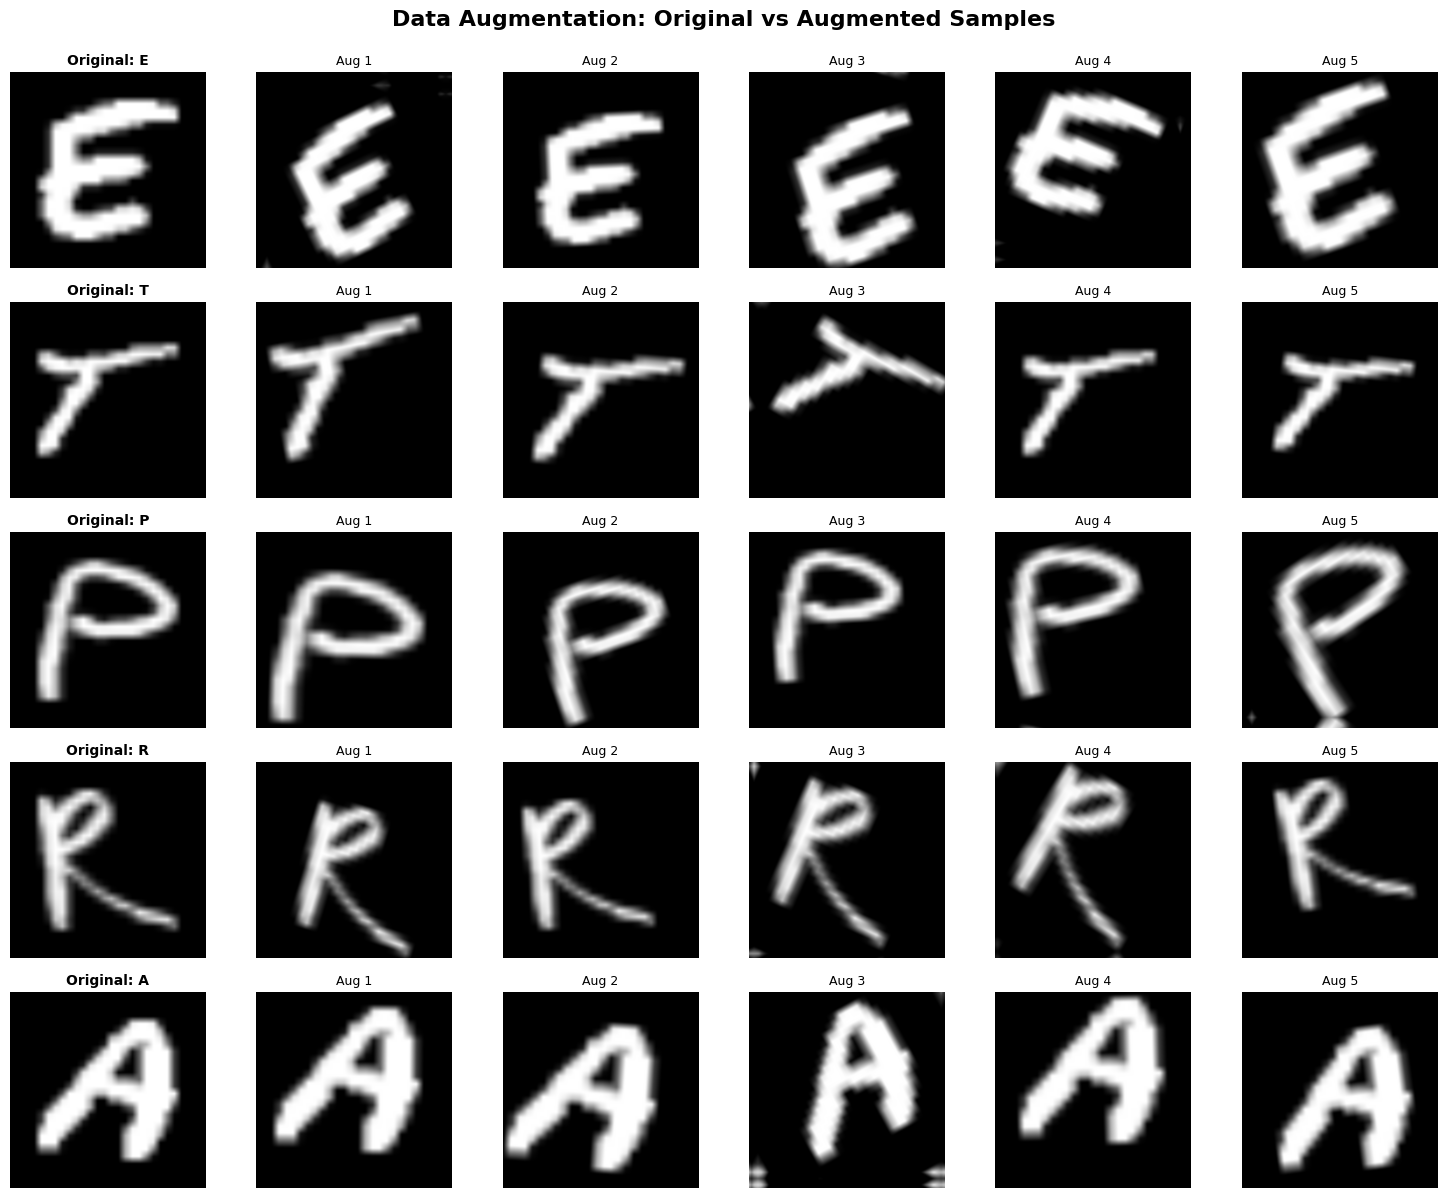

✓ Visual inspection: Rotation, zoom, and translation applied
✓ Augmentation demonstration complete!


In [11]:
print("AUGMENTATION VISUALIZATION")
print("="*60)

# Take 5 samples from training set
sample_images = X_train[:5]
sample_labels = y_train[:5]

# Create figure with original and augmented versions
fig, axes = plt.subplots(5, 6, figsize=(15, 12))

for i in range(5):
    # Original image (resized to 224x224 and converted to RGB)
    img = sample_images[i:i+1]
    img_resized = tf.image.resize(img, (224, 224))
    img_rgb = tf.image.grayscale_to_rgb(img_resized)
    
    # Plot original
    axes[i, 0].imshow(img_rgb[0].numpy())
    axes[i, 0].set_title(f'Original: {alpha[sample_labels[i]]}', fontsize=10, fontweight='bold')
    axes[i, 0].axis('off')
    
    # Generate 5 augmented versions
    for j in range(1, 6):
        augmented = data_augmentation(img_rgb, training=True)
        axes[i, j].imshow(augmented[0].numpy())
        axes[i, j].set_title(f'Aug {j}', fontsize=9)
        axes[i, j].axis('off')

plt.suptitle('Data Augmentation: Original vs Augmented Samples', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()
print("✓ Visual inspection: Rotation, zoom, and translation applied")
print("✓ Augmentation demonstration complete!")
print("="*60)


In [12]:
print("\n" + "="*60)
print("CREATING DATA PIPELINES")
print("="*60)

# Training dataset WITH augmentation (augmentation applied AFTER batching - more efficient)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = (
    train_ds.shuffle(10000)
    .map(preprocess_for_mobilenet, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH)
    .map(apply_augmentation_batched, num_parallel_calls=tf.data.AUTOTUNE)  # FIX: Apply augmentation to batches
    .prefetch(tf.data.AUTOTUNE)
)

# Validation dataset WITHOUT augmentation
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = (
    val_ds.map(preprocess_for_mobilenet, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH)
    .prefetch(tf.data.AUTOTUNE)
)

# Test dataset WITHOUT augmentation
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = (
    test_ds.map(preprocess_for_mobilenet, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH)
    .prefetch(tf.data.AUTOTUNE)
)

print(f"✓ Training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"✓ Validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"✓ Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")
print("="*60)



CREATING DATA PIPELINES
✓ Training batches: 4022
✓ Validation batches: 1006
✓ Test batches: 1257


In [13]:
print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)

base_model = MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)  # Standard MobileNet input
)

# IMPORTANT: Initially freeze, but we'll unfreeze later for fine-tuning
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # Increased capacity
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(26, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile for initial training
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Base Model: MobileNet (frozen)")
print(f"Input Shape: (224, 224, 3)")
print(f"Output Classes: 26 (A-Z)")
print(f"Total Parameters: {model.count_params():,}")
print(f"Trainable Parameters (Stage 1): {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")



MODEL ARCHITECTURE
Base Model: MobileNet (frozen)
Input Shape: (224, 224, 3)
Output Classes: 26 (A-Z)
Total Parameters: 3,891,674
Trainable Parameters (Stage 1): 662,810


In [15]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=7, 
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3,
    verbose=1,
    min_lr=1e-7
)



In [19]:
print("\n" + "="*60)
print("STAGE 1: TRAINING TOP LAYERS (Base Frozen)")
print("="*60)

history1 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)



STAGE 1: TRAINING TOP LAYERS (Base Frozen)
Epoch 1/10
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 627s 156ms/step - accuracy: 0.9615 - loss: 0.1431 - val_accuracy: 0.9832 - val_loss: 0.0668 - learning_rate: 1.0000e-04
Epoch 2/10
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 621s 154ms/step - accuracy: 0.9706 - loss: 0.1106 - val_accuracy: 0.9832 - val_loss: 0.0653 - learning_rate: 1.0000e-04
Epoch 3/10
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 628s 156ms/step - accuracy: 0.9761 - loss: 0.0888 - val_accuracy: 0.9860 - val_loss: 0.0543 - learning_rate: 1.0000e-04
Epoch 4/10
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 622s 155ms/step - accuracy: 0.9783 - loss: 0.0802 - val_accuracy: 0.9882 - val_loss: 0.0463 - learning_rate: 1.0000e-04
Epoch 5/10
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 615s 153ms/step - accuracy: 0.9811 - loss: 0.0689 - val_accuracy: 0.9860 - val_loss: 0.0544 - learning_rate: 1.0000e-04
Epoch 6/10
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 620s 154ms/step - accuracy: 0.9824 - loss: 0.0645 - val_accuracy: 0.9882 - val_loss: 0.0482 - learning_r

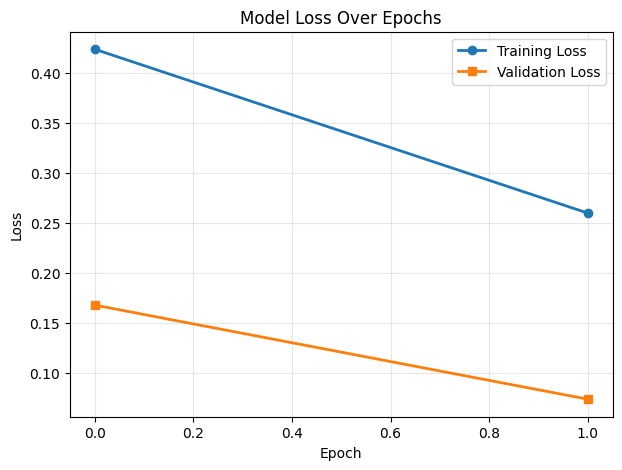

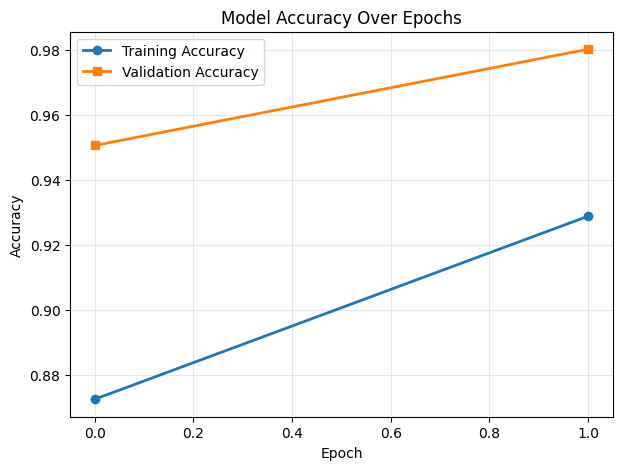


MOBILENET MODEL EVALUATION

✓ Test Accuracy: 98.97%
✓ Test Loss: 0.0416

Generating predictions on test set...

------------------------------------------------------------
DETAILED EVALUATION METRICS
------------------------------------------------------------

Macro-averaged metrics (equal weight to all classes):
  Precision: 0.9870
  Recall:    0.9877
  F1-Score:  0.9873

Weighted-averaged metrics (weighted by support):
  Precision: 0.9897
  Recall:    0.9897
  F1-Score:  0.9897

------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           A       1.00      0.99      0.99      1536
           B       0.99      0.99      0.99       961
           C       0.99      0.99      0.99      2434
           D       0.96      0.96      0.96      1086
           E       0.99      0.99      0.99      1208
           F       0.99      1.00      1.0

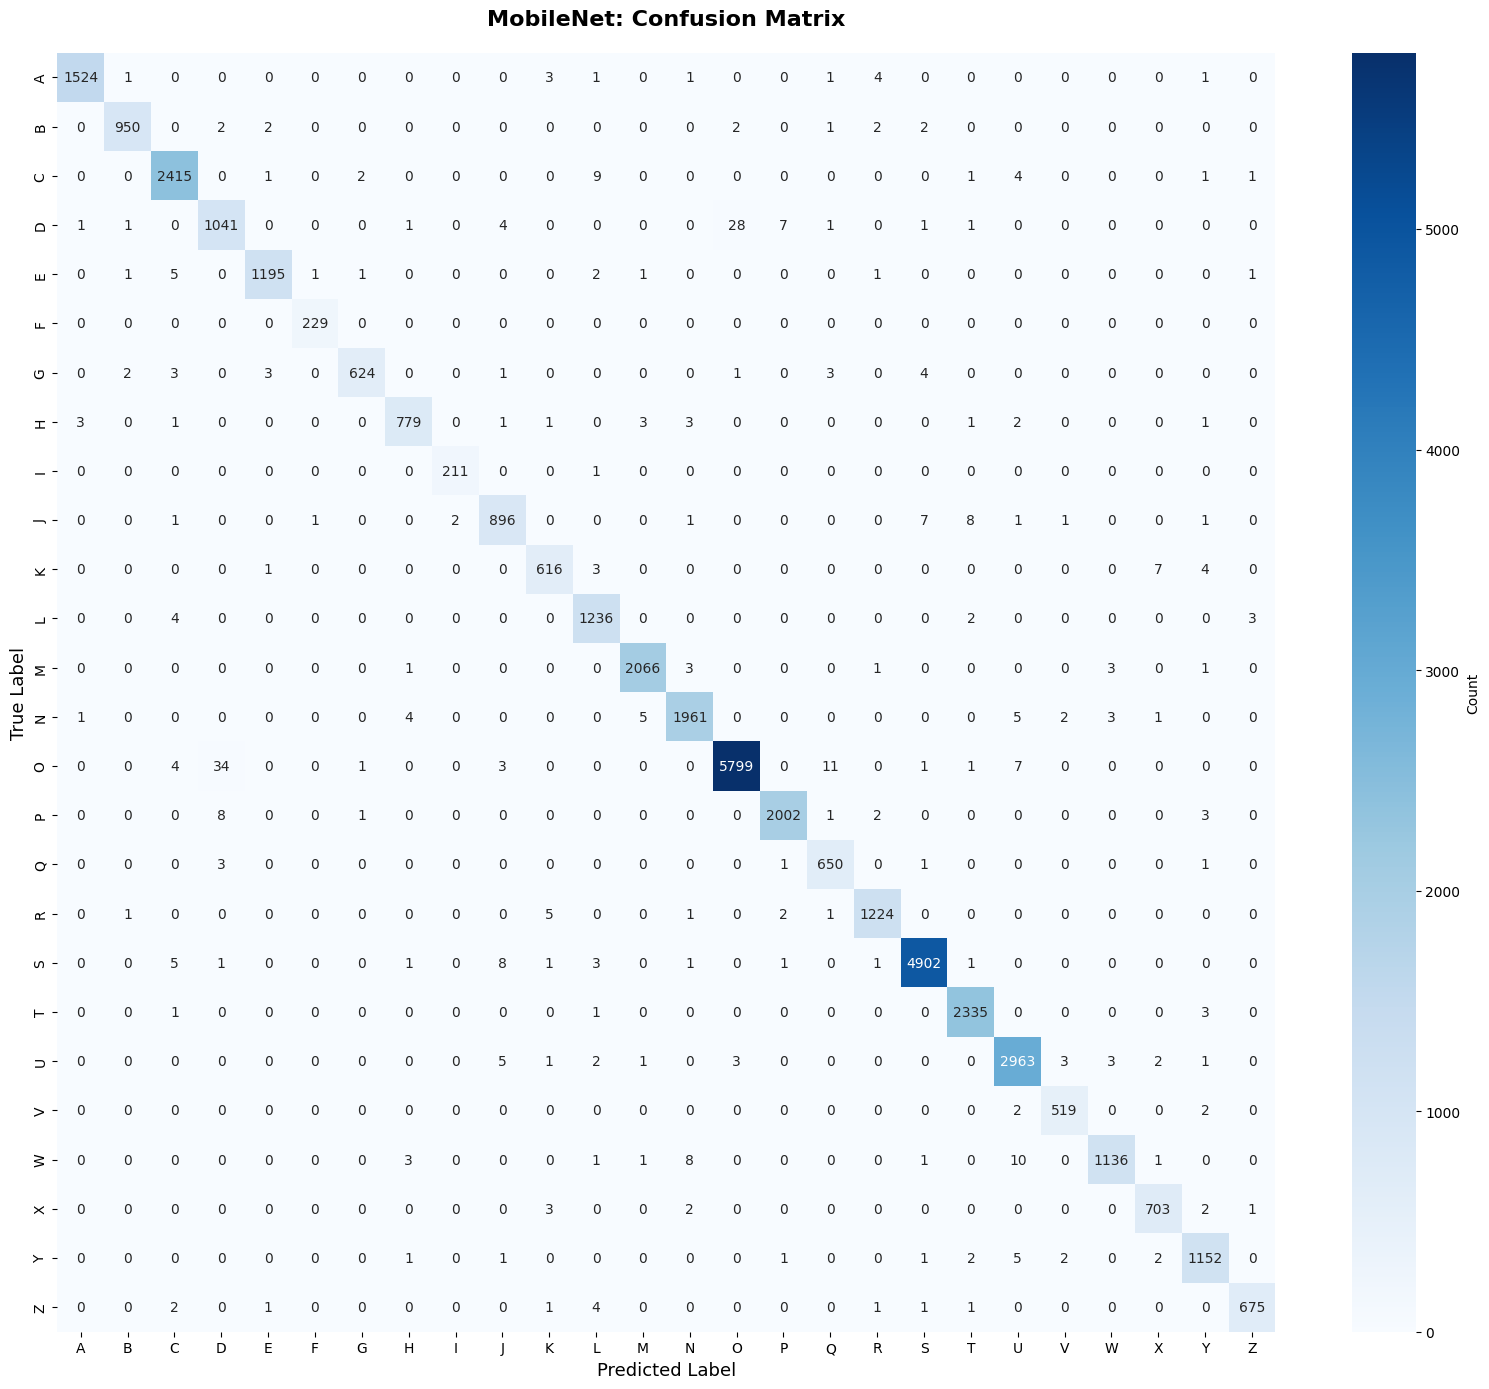

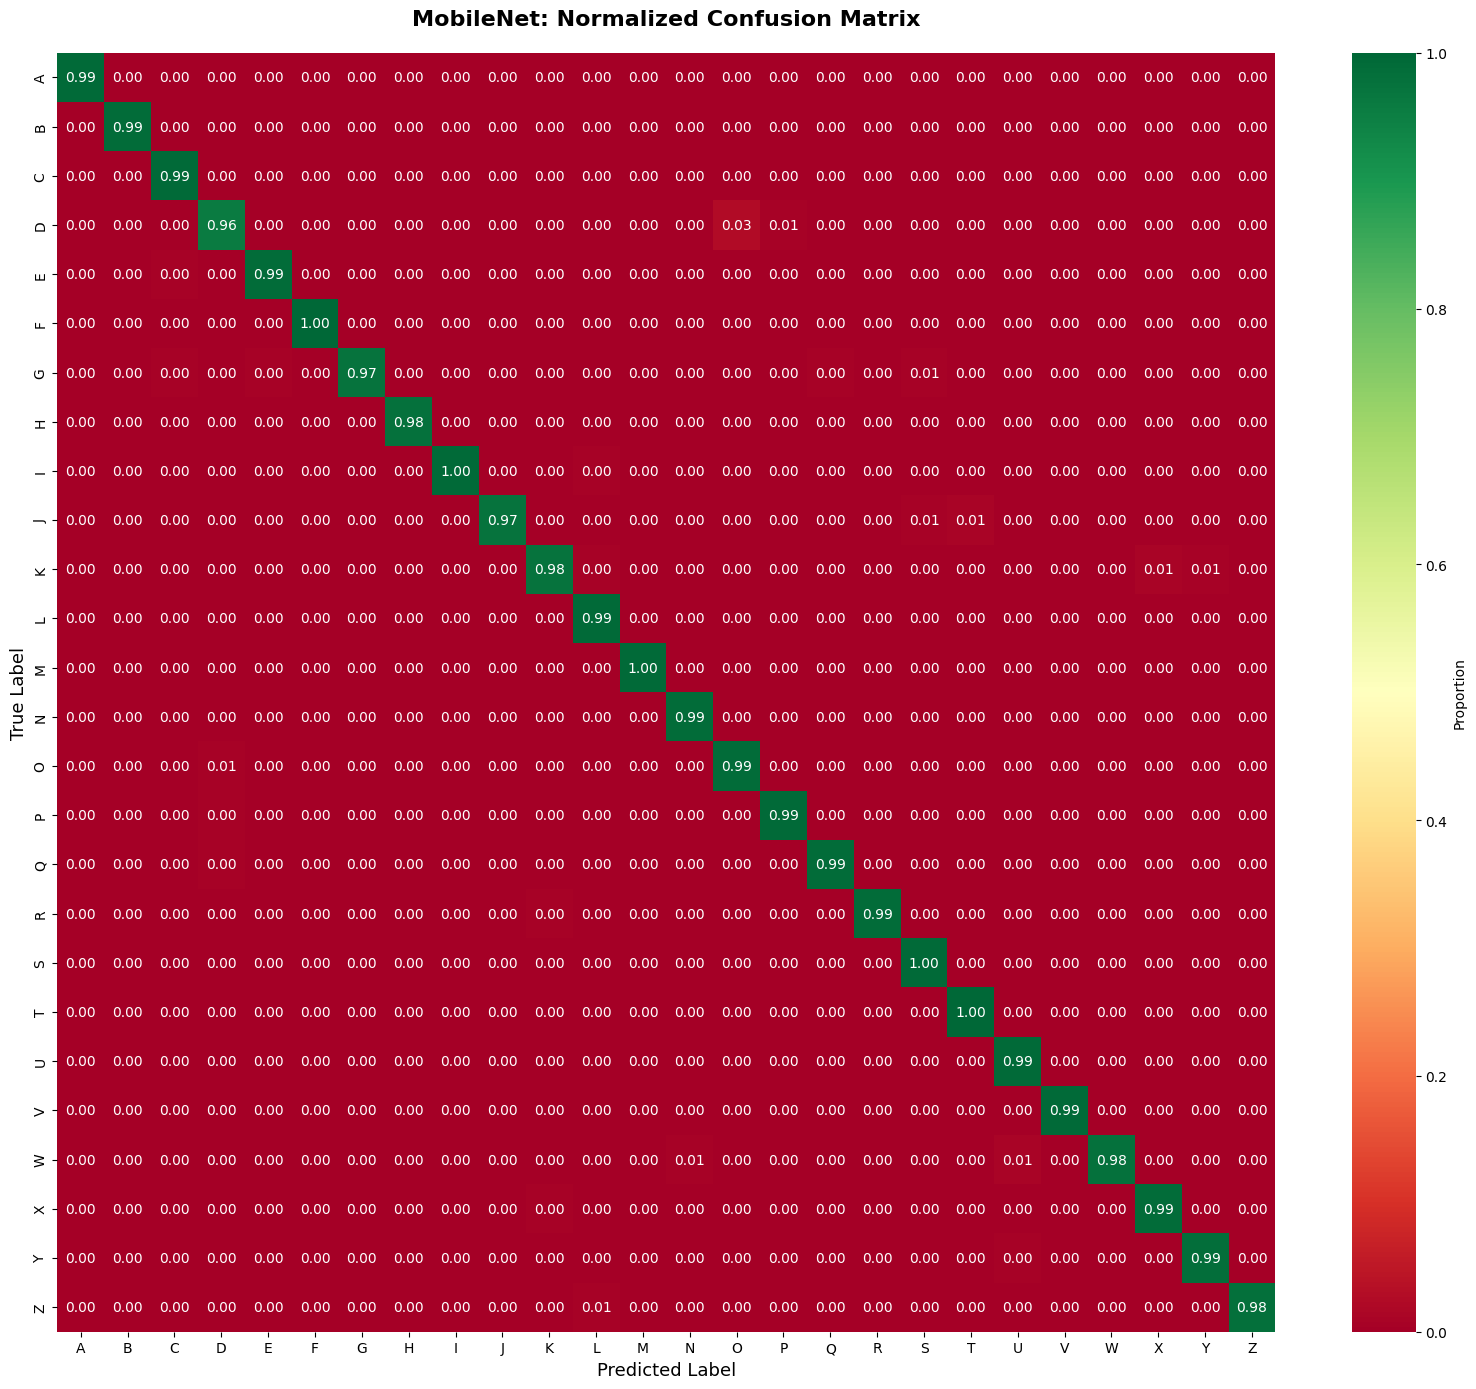


------------------------------------------------------------
ROC CURVE & AUC ANALYSIS
------------------------------------------------------------

Micro-average AUC: 0.9999
Macro-average AUC: 0.9999


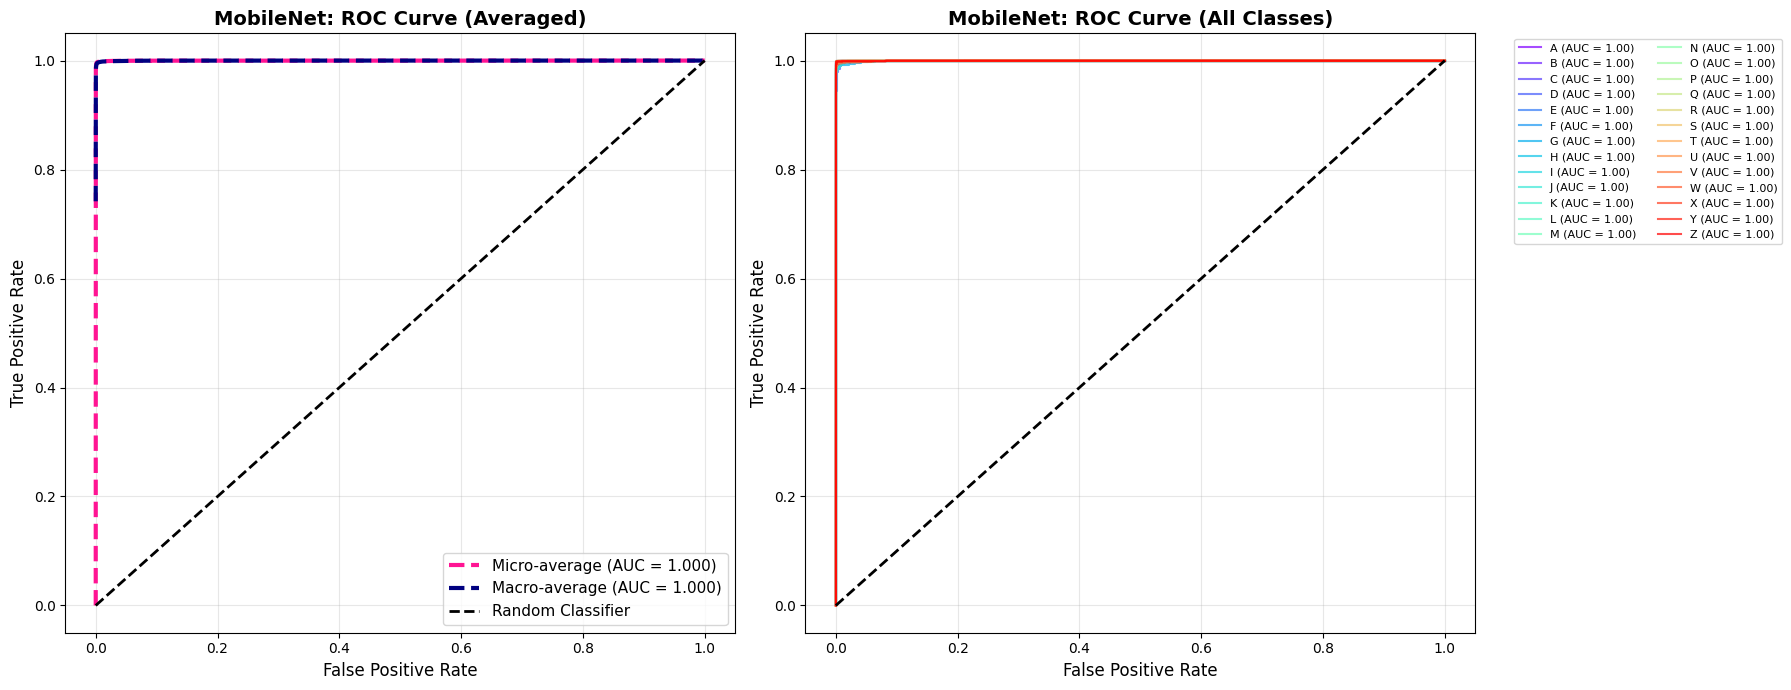


Per-class AUC scores:
  A: 1.0000
  B: 0.9999
  C: 0.9998
  D: 0.9996
  E: 1.0000
  F: 1.0000
  G: 0.9996
  H: 0.9999
  I: 1.0000
  J: 0.9996
  K: 0.9998
  L: 1.0000
  M: 0.9999
  N: 0.9998
  O: 0.9999
  P: 1.0000
  Q: 0.9999
  R: 1.0000
  S: 0.9998
  T: 1.0000
  U: 0.9999
  V: 1.0000
  W: 0.9997
  X: 1.0000
  Y: 0.9999
  Z: 0.9999

FINAL SUMMARY
✓ Model: MobileNet with Transfer Learning
✓ Input Size: 224×224×3
✓ Normalization: [0, 1]
✓ Data Split: Train 64% | Val 16% | Test 20%
✓ Data Augmentation: Rotation, Zoom, Translation (training only)

✓ Test Accuracy: 98.97%
✓ Macro-avg Precision: 0.9870
✓ Macro-avg Recall: 0.9877
✓ Macro-avg F1-Score: 0.9873
✓ Micro-average AUC: 0.9999
✓ Macro-average AUC: 0.9999


In [23]:
import matplotlib.pyplot as plt

# LOSS PLOT
plt.figure(figsize=(7, 5))
plt.plot(history_combined['loss'], label='Training Loss', linewidth=2, marker='o')
plt.plot(history_combined['val_loss'], label='Validation Loss', linewidth=2, marker='s')

plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

# ACCURACY PLOT
plt.figure(figsize=(7, 5))
plt.plot(history_combined['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
plt.plot(history_combined['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')

plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


# =========================
# EVALUATE ON TEST SET
# =========================
print("\n" + "="*60)
print("MOBILENET MODEL EVALUATION")
print("="*60)

test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\n✓ Test Accuracy: {test_acc*100:.2f}%")
print(f"✓ Test Loss: {test_loss:.4f}")

# =========================
# GET PREDICTIONS
# =========================
print("\nGenerating predictions on test set...")
y_pred_probs = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# =========================
# DETAILED METRICS
# =========================
print("\n" + "-"*60)
print("DETAILED EVALUATION METRICS")
print("-"*60)

# Calculate metrics with different averaging methods
precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)

precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("\nMacro-averaged metrics (equal weight to all classes):")
print(f"  Precision: {precision_macro:.4f}")
print(f"  Recall:    {recall_macro:.4f}")
print(f"  F1-Score:  {f1_macro:.4f}")

print("\nWeighted-averaged metrics (weighted by support):")
print(f"  Precision: {precision_weighted:.4f}")
print(f"  Recall:    {recall_weighted:.4f}")
print(f"  F1-Score:  {f1_weighted:.4f}")

# Classification report
print("\n" + "-"*60)
print("CLASSIFICATION REPORT")
print("-"*60)
print(classification_report(y_test, y_pred, target_names=alpha, zero_division=0))

# =========================
# CONFUSION MATRIX
# =========================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=alpha, yticklabels=alpha,
            cbar_kws={'label': 'Count'})
plt.title('MobileNet: Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13)
plt.ylabel('True Label', fontsize=13)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 14))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn', 
            xticklabels=alpha, yticklabels=alpha,
            vmin=0, vmax=1, cbar_kws={'label': 'Proportion'})
plt.title('MobileNet: Normalized Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13)
plt.ylabel('True Label', fontsize=13)
plt.tight_layout()
plt.show()

# =========================
# ROC CURVE & AUC (One-vs-Rest)
# =========================
print("\n" + "-"*60)
print("ROC CURVE & AUC ANALYSIS")
print("-"*60)

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(26))
n_classes = 26

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")
print(f"Macro-average AUC: {roc_auc['macro']:.4f}")

# Plot ROC curves
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Micro and Macro average
axes[0].plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle='--', linewidth=3)
axes[0].plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average (AUC = {roc_auc["macro"]:.3f})',
         color='navy', linestyle='--', linewidth=3)
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('MobileNet: ROC Curve (Averaged)', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: All individual classes
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    axes[1].plot(fpr[i], tpr[i], color=color, lw=1.5, alpha=0.7,
             label=f'{alpha[i]} (AUC = {roc_auc[i]:.2f})')

axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2)
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('MobileNet: ROC Curve (All Classes)', fontsize=14, fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Per-class AUC summary
print("\nPer-class AUC scores:")
for i in range(n_classes):
    print(f"  {alpha[i]}: {roc_auc[i]:.4f}")

# =========================
# FINAL SUMMARY
# =========================
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"✓ Model: MobileNet with Transfer Learning")
print(f"✓ Input Size: 224×224×3")
print(f"✓ Normalization: [0, 1]")
print(f"✓ Data Split: Train 64% | Val 16% | Test 20%")
print(f"✓ Data Augmentation: Rotation, Zoom, Translation (training only)")
print(f"\n✓ Test Accuracy: {test_acc*100:.2f}%")
print(f"✓ Macro-avg Precision: {precision_macro:.4f}")
print(f"✓ Macro-avg Recall: {recall_macro:.4f}")
print(f"✓ Macro-avg F1-Score: {f1_macro:.4f}")
print(f"✓ Micro-average AUC: {roc_auc['micro']:.4f}")
print(f"✓ Macro-average AUC: {roc_auc['macro']:.4f}")
print("="*60)